# Steps to create a Machine Learning Model:

1. Import required modules
2. Load data
3. Apply data augmentation and preprocessing
4. Create metrics for model performance
5. Write functions to plot graphs
6. Load and compile model
7. Train, validate and test
8. Save trained model

## 1. Import required modules

In [1]:
import numpy as np
from re import sub
import tensorflow as tf
from tensorflow.keras import metrics

import matplotlib.colors as mcolors

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image


import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image_dataset_from_directory

print("Done importing packages!")

Done importing packages!


## 2. Load data

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (240, 240)

In [3]:
data_dir = "../input/plantvillage-dataset/color"
train_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "training",
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "validation",
                                             image_size=IMG_SIZE)

Found 54305 files belonging to 38 classes.
Using 43444 files for training.
Found 54305 files belonging to 38 classes.
Using 10861 files for validation.


In [4]:
class_names = train_dataset.class_names
num_classes = len(class_names)
for i in range(1, num_classes + 1):
    print(str(i) + ". ", class_names[i - 1])

1.  Apple___Apple_scab
2.  Apple___Black_rot
3.  Apple___Cedar_apple_rust
4.  Apple___healthy
5.  Blueberry___healthy
6.  Cherry_(including_sour)___Powdery_mildew
7.  Cherry_(including_sour)___healthy
8.  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
9.  Corn_(maize)___Common_rust_
10.  Corn_(maize)___Northern_Leaf_Blight
11.  Corn_(maize)___healthy
12.  Grape___Black_rot
13.  Grape___Esca_(Black_Measles)
14.  Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
15.  Grape___healthy
16.  Orange___Haunglongbing_(Citrus_greening)
17.  Peach___Bacterial_spot
18.  Peach___healthy
19.  Pepper,_bell___Bacterial_spot
20.  Pepper,_bell___healthy
21.  Potato___Early_blight
22.  Potato___Late_blight
23.  Potato___healthy
24.  Raspberry___healthy
25.  Soybean___healthy
26.  Squash___Powdery_mildew
27.  Strawberry___Leaf_scorch
28.  Strawberry___healthy
29.  Tomato___Bacterial_spot
30.  Tomato___Early_blight
31.  Tomato___Late_blight
32.  Tomato___Leaf_Mold
33.  Tomato___Septoria_leaf_spot
34.  Tomato_

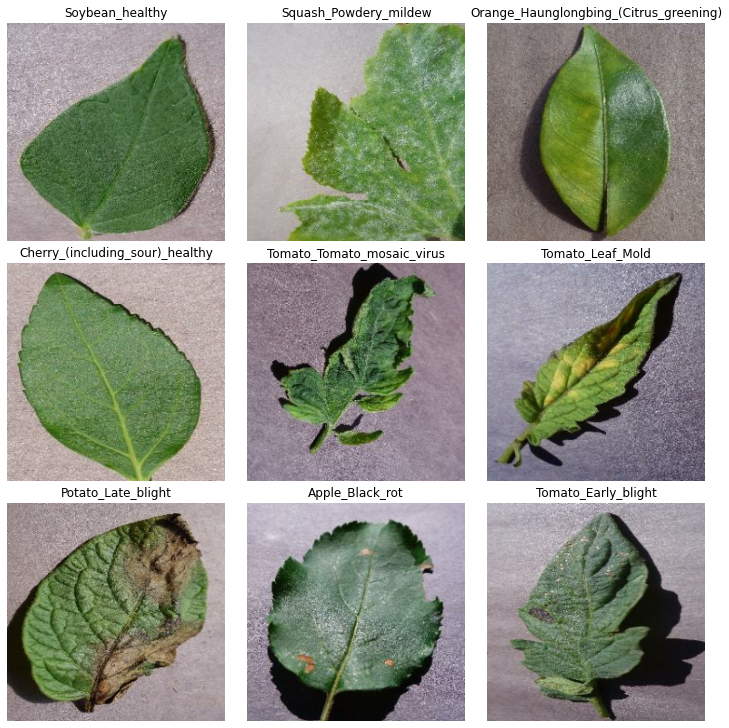

In [5]:
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = sub(r"[_]+","_",class_names[np.argmax(labels[i])])
        plt.title(title)
        plt.axis("off")

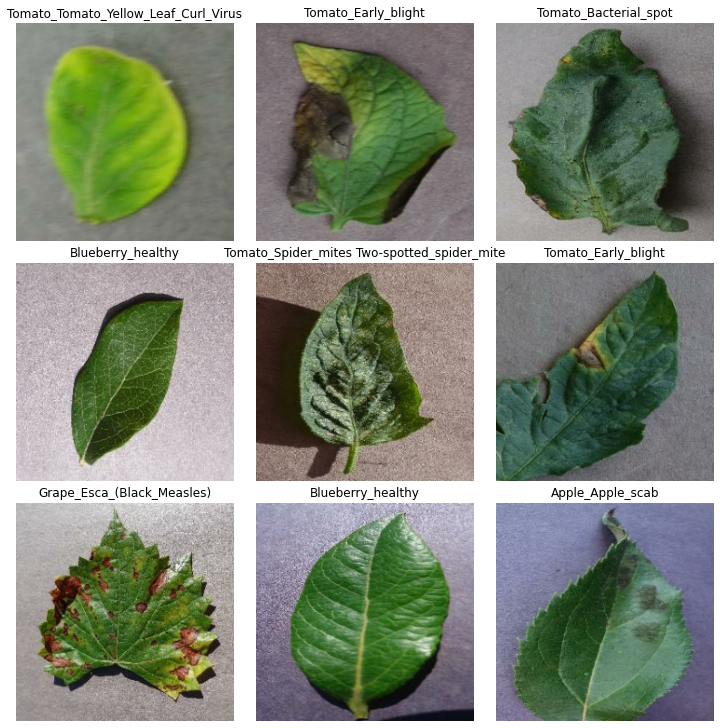

In [6]:
plt.figure(figsize=(10, 10), constrained_layout=True)
for images, labels in validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = sub(r"[_]+","_",class_names[np.argmax(labels[i])])
        plt.title(title)
        plt.axis("off")

## 3. Data Augmentation and preprocessing

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 272
Number of test batches: 68


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
# add more augmentations
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

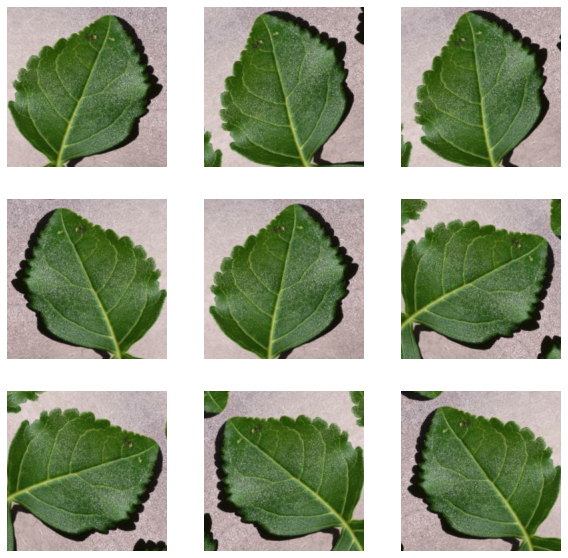

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## 4. Metrics and Plotting functions

In [11]:
def plot_metrics(history):
  colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
  metrics = ['loss', 'auc', 'precision', 'recall']
  plt.figure(figsize=(20,10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [12]:
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc')
]

## 5. Load and compile model

In [13]:
IMG_SHAPE = IMG_SIZE + (3,)

In [14]:
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

In [15]:
# base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')
base_model = tf.keras.applications.InceptionResNetV2(
                                include_top=False,
                                weights="imagenet",
                                input_shape=IMG_SHAPE,
                            )

219062272/219055592 [==============================] - 2s 0us/step


In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1536)


In [17]:
base_model.trainable = False

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

(32, 1536)


In [19]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 38)


In [20]:
inputs = tf.keras.Input(shape=(240, 240, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 240, 240, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 240, 240, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 240, 240, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 6, 6, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0     

In [23]:
len(model.trainable_variables)

2

## 6. Training, Validation and Testing

### 6.1 Before tuning

In [24]:
initial_epochs = 10

In [25]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
1358/1358 [==============================] - 577s 413ms/step - loss: 1.3254 - tp: 11834.7498 - fp: 962.9478 - tn: 804155.5276 - fn: 9925.2090 - accuracy: 0.6500 - precision: 0.9118 - recall: 0.4603 - auc: 0.9568 - val_loss: 0.4498 - val_tp: 6950.0000 - val_fp: 432.0000 - val_tn: 320913.0000 - val_fn: 1735.0000 - val_accuracy: 0.8722 - val_precision: 0.9415 - val_recall: 0.8002 - val_auc: 0.9967
Epoch 2/10
1358/1358 [==============================] - 238s 175ms/step - loss: 0.4533 - tp: 17486.8595 - fp: 1365.7940 - tn: 803752.6814 - fn: 4273.0993 - accuracy: 0.8649 - precision: 0.9257 - recall: 0.7980 - auc: 0.9957 - val_loss: 0.3324 - val_tp: 7432.0000 - val_fp: 465.0000 - val_tn: 320880.0000 - val_fn: 1253.0000 - val_accuracy: 0.8986 - val_precision: 0.9411 - val_recall: 0.8557 - val_auc: 0.9977
Epoch 3/10
1358/1358 [==============================] - 240s 176ms/step - loss: 0.3708 - tp: 18402.1501 - fp: 1349.5931 - tn: 803768.8823 - fn: 3357.8087 - accuracy: 0.8874 - precis

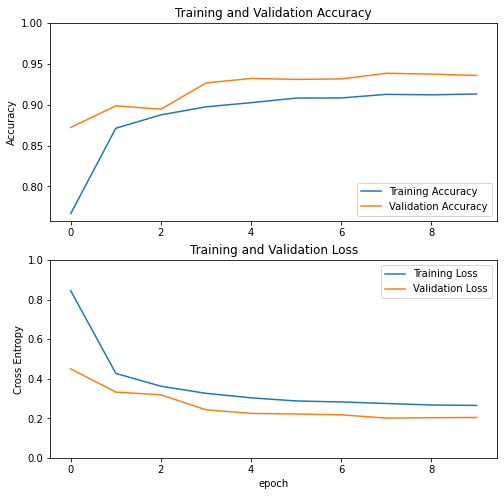

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

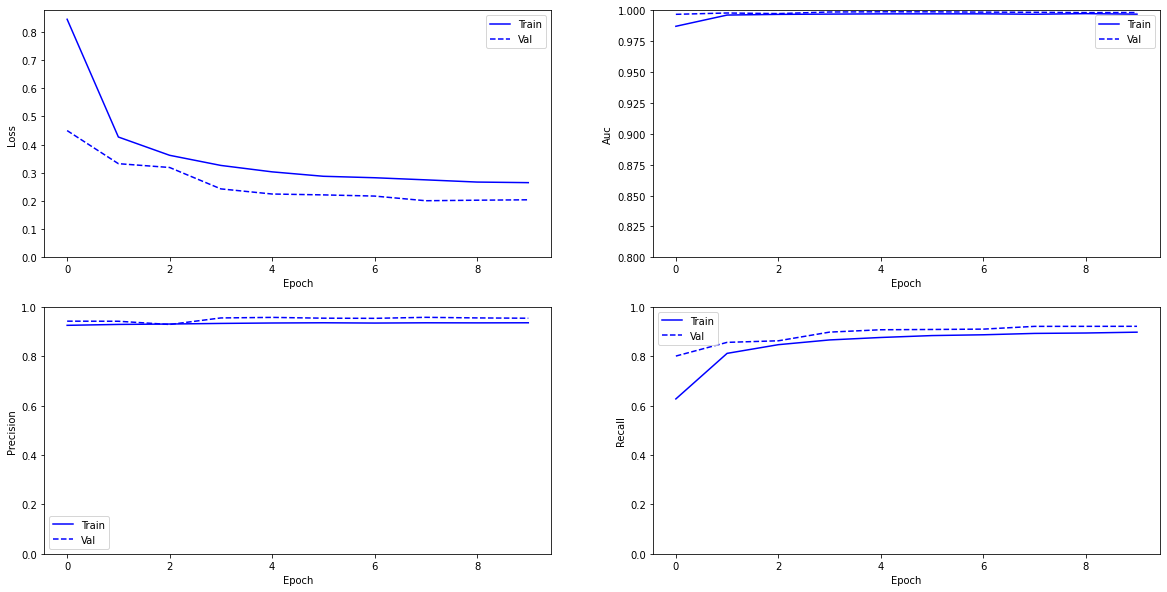

In [27]:
plot_metrics(history)

### 6.2 After Tuning

In [28]:
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 700

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  780


In [30]:
fine_tuning_learning_rate = 1e-5
model.compile(optimizer=tf.keras.optimizers.Adam(lr=fine_tuning_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 240, 240, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 240, 240, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 240, 240, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 6, 6, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0     

In [32]:
len(model.trainable_variables)

52

In [33]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/25
1358/1358 [==============================] - 304s 212ms/step - loss: 0.1910 - tp: 28180.7130 - fp: 1395.7093 - tn: 1125067.7660 - fn: 2264.2458 - accuracy: 0.9371 - precision: 0.9520 - recall: 0.9238 - auc: 0.9983 - val_loss: 0.1095 - val_tp: 8311.0000 - val_fp: 250.0000 - val_tn: 321095.0000 - val_fn: 374.0000 - val_accuracy: 0.9626 - val_precision: 0.9708 - val_recall: 0.9569 - val_auc: 0.9995
Epoch 11/25
1358/1358 [==============================] - 271s 199ms/step - loss: 0.1240 - tp: 20727.3142 - fp: 701.2914 - tn: 804417.1840 - fn: 1032.6446 - accuracy: 0.9588 - precision: 0.9661 - recall: 0.9512 - auc: 0.9993 - val_loss: 0.0899 - val_tp: 8379.0000 - val_fp: 221.0000 - val_tn: 321124.0000 - val_fn: 306.0000 - val_accuracy: 0.9696 - val_precision: 0.9743 - val_recall: 0.9648 - val_auc: 0.9996
Epoch 12/25
1358/1358 [==============================] - 269s 197ms/step - loss: 0.0942 - tp: 20976.8396 - fp: 546.2686 - tn: 804572.2068 - fn: 783.1192 - accuracy: 0.9672 - precis

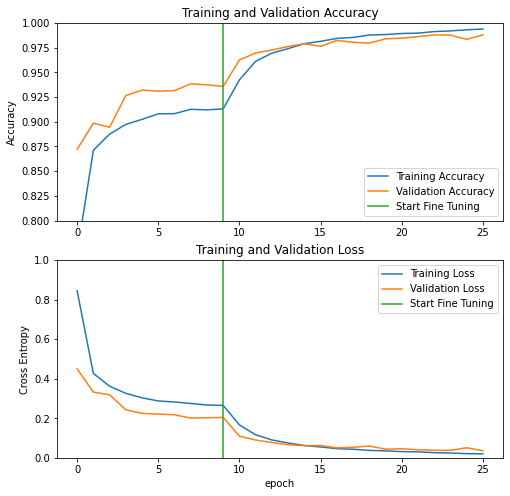

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']



plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.show()

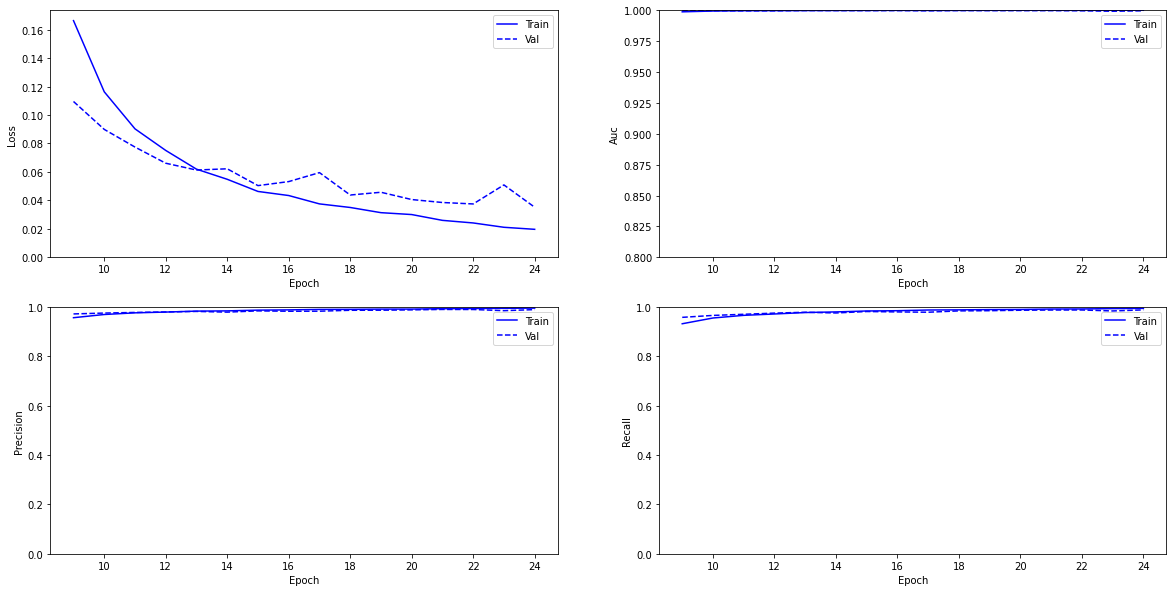

In [35]:
plot_metrics(history_fine)

In [36]:
result = model.evaluate(test_dataset)

68/68 [==============================] - 10s 138ms/step - loss: 0.0473 - tp: 2149.0000 - fp: 25.0000 - tn: 80487.0000 - fn: 27.0000 - accuracy: 0.9876 - precision: 0.9885 - recall: 0.9876 - auc: 0.9993


In [37]:
metrics = ["loss", "tp", "fp", "tn", "fn", "accuracy", "precision", "recall", "auc"]
for i in range(len(result)):
    print("{} : {}".format(metrics[i],round(result[i], 3)))

loss : 0.047
tp : 2149.0
fp : 25.0
tn : 80487.0
fn : 27.0
accuracy : 0.988
precision : 0.989
recall : 0.988
auc : 0.999


Predictions:
 [17, 12, 35, 11, 15, 12, 19, 0, 15, 20, 35, 24, 13, 37, 15, 20, 35, 32, 30, 35, 28, 13, 33, 33, 34, 3, 35, 2, 35, 18, 15, 32]
Labels:
 [17, 12, 35, 11, 15, 12, 19, 0, 15, 20, 35, 24, 13, 37, 15, 20, 35, 32, 30, 35, 28, 13, 33, 33, 34, 3, 35, 2, 35, 18, 15, 32]


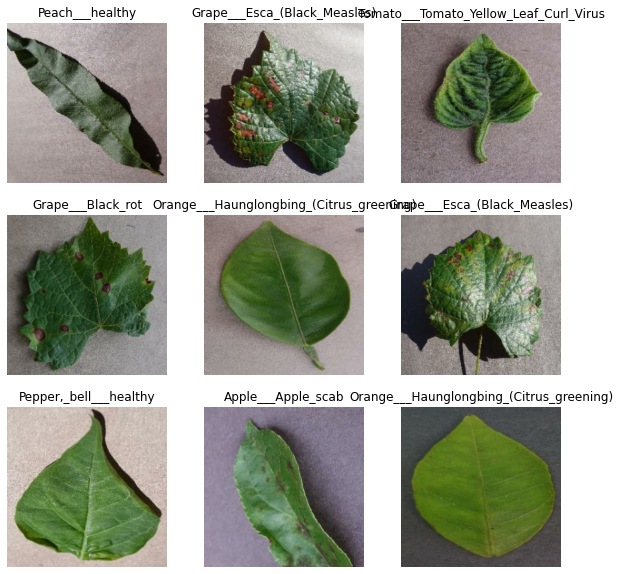

In [38]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = tf.nn.softmax(predictions)
predictions = list(np.argmax(x) for x in predictions.numpy())

print('Predictions:\n', predictions)
print('Labels:\n', list(np.argmax(x) for x in label_batch))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")